In [3]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json
#import requests


load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Bukit_Batok'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 2355


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
127920,BUKIT BATOK,3 ROOM,283,BT BATOK EAST AVE 3,64.0,Simplified,1988,64 years 10 months,330000.0,2.0,65.0
127921,BUKIT BATOK,3 ROOM,264,BT BATOK EAST AVE 4,73.0,Model A,1985,61 years 11 months,350000.0,5.0,65.0
127922,BUKIT BATOK,3 ROOM,238,BT BATOK EAST AVE 5,67.0,New Generation,1986,63 years 06 months,350000.0,5.0,65.0
127923,BUKIT BATOK,3 ROOM,249,BT BATOK EAST AVE 5,73.0,Model A,1985,61 years 10 months,360000.0,8.0,65.0
127924,BUKIT BATOK,3 ROOM,239,BT BATOK EAST AVE 5,67.0,New Generation,1985,61 years 09 months,363000.0,14.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152572,BUKIT BATOK,5 ROOM,443A,BT BATOK WEST AVE 8,112.0,Improved,2019,94 years 11 months,703888.0,8.0,76.0
152573,BUKIT BATOK,5 ROOM,445A,BT BATOK WEST AVE 8,112.0,Improved,2019,94 years 09 months,725000.0,2.0,76.0
152574,BUKIT BATOK,5 ROOM,446A,BT BATOK WEST AVE 8,112.0,Improved,2019,94 years 08 months,770888.0,8.0,76.0
152575,BUKIT BATOK,EXECUTIVE,289D,BT BATOK ST 25,165.0,Maisonette,1997,73 years 08 months,1088000.0,5.0,76.0


In [5]:
blk_street = df.block + ' ' + df.street_name

#longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


0 of 306
10 of 306
20 of 306
30 of 306
40 of 306
50 of 306
60 of 306
70 of 306
80 of 306
90 of 306
100 of 306
110 of 306
120 of 306
130 of 306
140 of 306
150 of 306
160 of 306
170 of 306
180 of 306
190 of 306
200 of 306
210 of 306
220 of 306
230 of 306
240 of 306
250 of 306
260 of 306
270 of 306
280 of 306
290 of 306
300 of 306
0 errors detected


TypeError: dump_pkl() missing 1 required positional argument: 'longLats'

In [6]:
dump_pkl(longLats)

pickle dumped. 2661


In [7]:
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
127920,BUKIT BATOK,3 ROOM,283,BT BATOK EAST AVE 3,64.0,Simplified,1988,64 years 10 months,330000.0,2.0,65.0
127921,BUKIT BATOK,3 ROOM,264,BT BATOK EAST AVE 4,73.0,Model A,1985,61 years 11 months,350000.0,5.0,65.0
127922,BUKIT BATOK,3 ROOM,238,BT BATOK EAST AVE 5,67.0,New Generation,1986,63 years 06 months,350000.0,5.0,65.0
127923,BUKIT BATOK,3 ROOM,249,BT BATOK EAST AVE 5,73.0,Model A,1985,61 years 10 months,360000.0,8.0,65.0
127924,BUKIT BATOK,3 ROOM,239,BT BATOK EAST AVE 5,67.0,New Generation,1985,61 years 09 months,363000.0,14.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152572,BUKIT BATOK,5 ROOM,443A,BT BATOK WEST AVE 8,112.0,Improved,2019,94 years 11 months,703888.0,8.0,76.0
152573,BUKIT BATOK,5 ROOM,445A,BT BATOK WEST AVE 8,112.0,Improved,2019,94 years 09 months,725000.0,2.0,76.0
152574,BUKIT BATOK,5 ROOM,446A,BT BATOK WEST AVE 8,112.0,Improved,2019,94 years 08 months,770888.0,8.0,76.0
152575,BUKIT BATOK,EXECUTIVE,289D,BT BATOK ST 25,165.0,Maisonette,1997,73 years 08 months,1088000.0,5.0,76.0


In [8]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,1089.000000,1089.000000,1.089000e+03,1089.000000,1089.000000,1089.000000,1089.000000
mean,94.862259,2000.444444,5.595286e+05,10.101928,71.055096,103.748697,1.351392
std,24.264348,15.391786,1.681010e+05,7.357699,3.513458,0.006203,0.006566
min,37.000000,1983.000000,2.500000e+05,2.000000,65.000000,103.737201,1.338763
25%,73.000000,1985.000000,4.200000e+05,5.000000,68.000000,103.744616,1.345575
50%,93.000000,1997.000000,5.280000e+05,8.000000,72.000000,103.748024,1.350447
75%,112.000000,2019.000000,6.980000e+05,14.000000,74.000000,103.754194,1.355602
max,165.000000,2019.000000,1.088000e+06,38.000000,76.000000,103.760618,1.366378


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

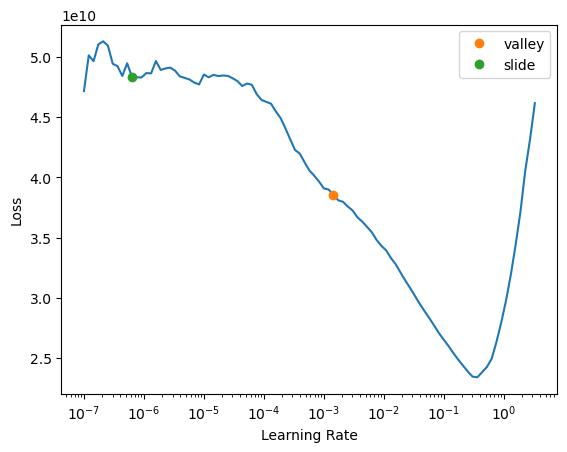

In [9]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [12]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 29761.369140625.


(#2) [891621952.0,29761.369140625]

In [13]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 6*20
n2 = 7*20
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 140
10 of 140
20 of 140
30 of 140
40 of 140
50 of 140
60 of 140
70 of 140
80 of 140
90 of 140
100 of 140
110 of 140
120 of 140
130 of 140


In [14]:
import http.client, urllib.parse
import json

mrts = ["Bukit Gombak MRT", "Bukit Batok MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt[:-4] + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 3284
Bukit Gombak Station, Singapore, confidence 1
Bukit Batok Fire Station, Singapore, confidence 1
pickle dumped. 3286


In [23]:
longLats['Bukit Batok MRT'] = (103.74956,1.34899)
dump_pkl(longLats)

pickle dumped. 3286


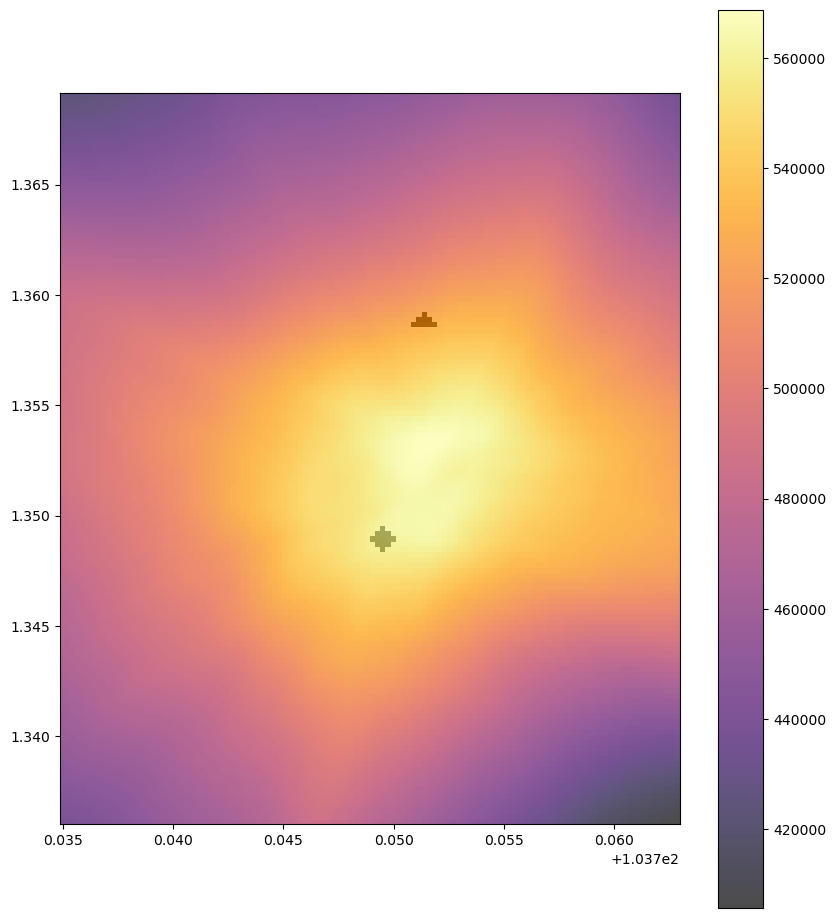

In [24]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_up(*min_coords(*longLats[mrts[0]]))
map_star(*min_coords(*longLats[mrts[1]]))


fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

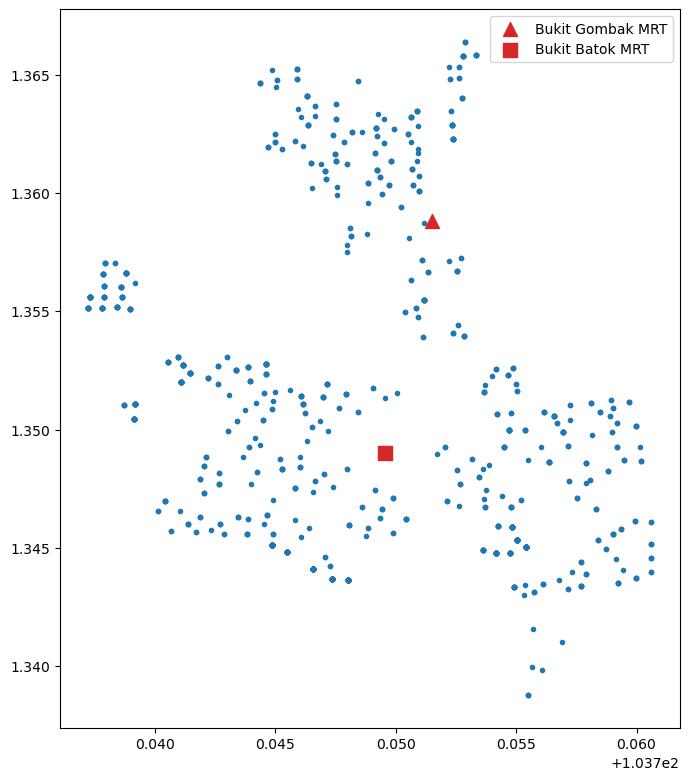

In [26]:
markers = ["^", 's']

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='upper right')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
